# Bird Image Classification Project

## Imports and Data Loading

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
!pip install datasets

In [ ]:
!pip install evaluate

In [113]:
# Imports
from datasets import load_dataset
import evaluate
from glob import glob
from huggingface_hub import notebook_login
import imagesize
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import random
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from transformers import create_optimizer, DefaultDataCollator, TFViTForImageClassification as ViTForImageClassification, ViTImageProcessor
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [114]:
# Define path to data directory
data_dir = os.path.join('drive', 'MyDrive', 'ConcordiaBootcamp', 'Data', 'birds')

In [115]:
# Load dataset
dataset = load_dataset(path=data_dir)

Resolving data files:   0%|          | 0/3208 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

## EDA

In [ ]:
# Get subfolders
subfolders = [d.name for d in Path(data_dir).iterdir() if d.is_dir()]
subfolders

In [ ]:
# Get dataset structure
dataset

In [ ]:
# Get total number of images in dataset
complete_list = list(Path(data_dir).glob('*/*/*.jpg'))
nb_images = len(complete_list)
nb_images

In [ ]:
# Get number of images to predict
pred_dir = os.path.join(data_dir, 'images to predict')
pred_img_paths = list(Path(pred_dir).glob('*.jpg'))
pred_size = len(pred_img_paths)
pred_size

In [ ]:
# Load one image from dataset at random
np.random.seed(42)
random_set = np.random.choice(['train', 'validation', 'test'])
random_item = np.random.choice(dataset[random_set])
display(random_item['image'])

In [ ]:
# Get size of that image
random_item['image'].size

## Data Preprocessing

In [ ]:
# Load image processor
checkpoint = 'google/vit-base-patch16-224'
image_processor = ViTImageProcessor.from_pretrained(checkpoint)
image_processor.save_pretrained('bird_classifier', push_to_hub=True)
image_processor

In [ ]:
# Define size
size = (image_processor.size['height'], image_processor.size['width'])
#size = (128, 128)

In [ ]:
# Define train dataset
train_data_augmentation = keras.Sequential(
  [
    #keras.layers.RandomCrop(size[0], size[1]),
    keras.layers.Rescaling(scale=1./255, offset=-1),
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(factor=0.02),
    keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
  ],
  name='train_data_augmentation',
)

In [ ]:
# Define validation dataset
val_data_augmentation = keras.Sequential(
    [
        #keras.layers.CenterCrop(size[0], size[1]),
        keras.layers.Rescaling(scale=1./255, offset=-1),
    ],
    name='val_data_augmentation',
)

In [ ]:
# Create functions to apply appropriate transformations
def convert_to_tf_tensor(image: Image):
  np_image = np.array(image)
  tf_image = tf.convert_to_tensor(np_image)

  return tf.expand_dims(tf_image, 0)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    images = [
        train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch['image']
    ]
    example_batch['pixel_values'] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert('RGB'))) for image in example_batch['image']
    ]
    example_batch['pixel_values'] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

def preprocess_test(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        test_data(convert_to_tf_tensor(image.convert('RGB'))) for image in example_batch['image']
    ]
    example_batch['pixel_values'] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

In [ ]:
# Apply transformations
dataset['train'].set_transform(preprocess_train)
dataset['validation'].set_transform(preprocess_val)
dataset['test'].set_transform(preprocess_test)

In [ ]:
# Define data collator
data_collator = DefaultDataCollator(return_tensors="tf")

## Data Modeling

### Load pre-trained model

In [ ]:
# Create mapping for categories
labels = dataset['train'].features['label'].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [ ]:
label2id

In [ ]:
id2label

In [ ]:
!pip install huggingface_hub[hf_xet]

In [ ]:
# Initialize the model
model = ViTForImageClassification.from_pretrained(checkpoint)

In [ ]:
# Get some images from the validation set
np.random.seed(42)
random_dataset = np.random.choice(dataset['validation'], 5, replace=False)

preds = []
for item in random_dataset:
  preds.append({
      'image': item['image'],
      'actual': id2label[str(item['label'])]
  })

preds_df = pd.DataFrame(preds)
preds_df

In [ ]:
# Display images
images = preds_df['image'].to_list()
labels = preds_df['actual'].to_list()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

for i in range(5):
    axes[i].imshow(images[i])
    axes[i].title.set_text(labels[i])
    axes[i].axis("off")

fig.tight_layout()
plt.show()

In [ ]:
# Make predictions
inputs = image_processor(images=images, return_tensors="tf")
outputs = model(**inputs)
logits = outputs.logits
logits

In [ ]:
# Show predictions
predicted = []

for logit in logits:
  predicted_class_idx = logit.numpy().argmax(-1).item()
  predicted.append(model.config.id2label[predicted_class_idx])

pd.set_option('display.max_colwidth', None)
preds_df.insert(1, 'predicted' , pd.Series(predicted))
preds_df[['predicted', 'actual']]

### Fine-tune model

In [ ]:
# Load accuracy to evaluate model
accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
# Define optimizer
batch_size = 32
num_epochs = 5
num_train_steps = len(dataset['train']) * num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [ ]:
# Load model with label mappings
model = ViTForImageClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

In [ ]:
model.summary()

In [ ]:
# Convert datasets to tf.data.Dataset
tf_train_dataset = dataset['train'].to_tf_dataset(
    columns='pixel_values', label_cols='label', shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
tf_val_dataset = dataset['validation'].to_tf_dataset(
    columns='pixel_values', label_cols='label', shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

In [ ]:
# Configure the model for training
loss = SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

In [ ]:
# Fit model
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_val_dataset, batch_size=batch_size)
model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs, callbacks=metric_callback)

In [ ]:
# Login to hugging face hub
notebook_login()

In [ ]:
# Push model to hub
model.push_to_hub('bird_classifier')

In [ ]:
metrics = pd.DataFrame(model.history.history)
metrics

In [ ]:
# Plot training vs. validation loss
metrics[['loss','val_loss']].plot();

### Inference

In [116]:
# Load image processor
checkpoint = 'nadpierre/bird_classifier'
image_processor = ViTImageProcessor.from_pretrained(checkpoint)
image_processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [117]:
# Load model
model = ViTForImageClassification.from_pretrained(checkpoint)

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at nadpierre/bird_classifier.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [134]:
# Get predicted class for one image
item = dataset['validation'][0]
img_to_test = item['image']
inputs = image_processor(img_to_test, return_tensors='tf')
logits = model(**inputs).logits

predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
predicted = model.config.id2label[predicted_class_id]
actual = id2label[str(item['label'])]

print('Predicted class: {}\nActual class: {}'.format(predicted, actual))

Predicted class: ABBOTTS BABBLER
Actual class: ABBOTTS BABBLER


### Evaluation

In [135]:
# Shuffle test dataset
test_dataset = dataset['test'].shuffle(seed=42)

In [136]:
# Create predicted vs. actual dataframe
preds = []
for item in test_dataset:
  actual = item['label']

  inputs = image_processor(item['image'], return_tensors='tf')
  logits = model(**inputs).logits

  preds.append({
      'predicted': int(tf.math.argmax(logits, axis=-1)[0]),
      'actual': actual
  })

preds_df = pd.DataFrame(preds)
preds_df

,predicted,actual
0,11,11
1,4,4
2,11,11
3,3,3
4,6,6
...,...,...
95,13,13
96,7,7
97,13,13
98,15,15


In [156]:
# Build classification report
print(classification_report(
    y_true=preds_df['actual'],
    y_pred=preds_df['predicted'],
    labels=range(20),
    target_names=id2label.values()))

                            precision    recall  f1-score   support

           ABBOTTS BABBLER       1.00      1.00      1.00         5
             ABBOTTS BOOBY       1.00      1.00      1.00         5
ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
     AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
    AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
         AFRICAN FIREFINCH       1.00      1.00      1.00         5
    AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
     AFRICAN PIED HORNBILL       1.00      1.00      1.00         5
       AFRICAN PYGMY GOOSE       1.00      1.00      1.00         5
                 ALBATROSS       1.00      1.00      1.00         5
            ALBERTS TOWHEE       1.00      1.00      1.00         5
      ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
             ALPINE CHOUGH       1.00      1.00      1.00         5
     ALTAMIRA YELLOWTHROAT       1.00      1.00

## Make predictions

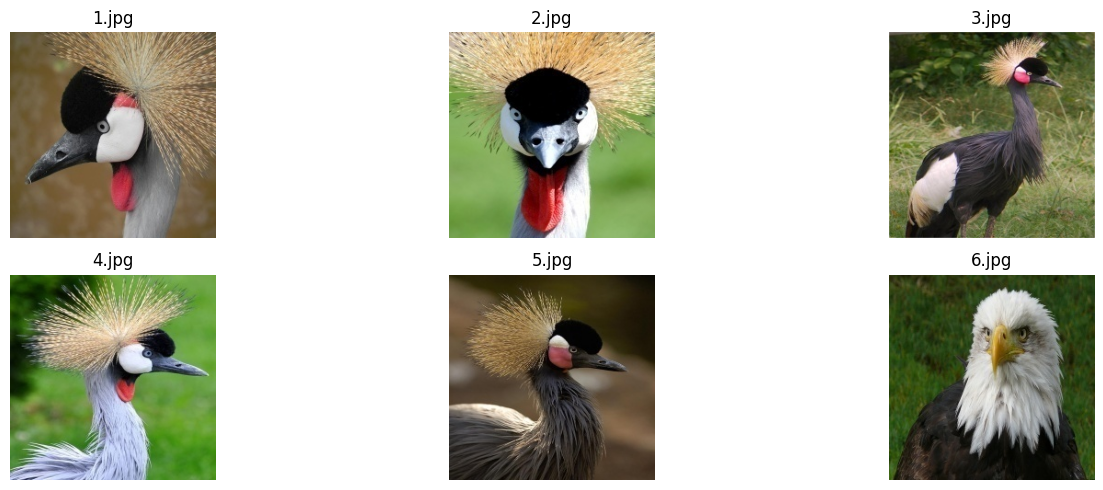

In [170]:
# Display images
pred_img_paths = sorted(pred_img_paths)
images = []

nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(15,5))

for i in range(nrows):
  for j in range(ncols):
    index = (i * ncols) + (j % ncols)
    img = Image.open(pred_img_paths[index])
    images.append(img)
    axes[i, j].imshow(img)
    axes[i, j].title.set_text(os.path.basename(pred_img_paths[index]))
    axes[i, j].axis("off")

fig.tight_layout()
plt.show()

In [171]:
# Make predictions
inputs = image_processor(images=images, return_tensors="tf")
outputs = model(**inputs)
logits = outputs.logits
logits

<tf.Tensor: shape=(6, 20), dtype=float32, numpy=
array([[-1.99163809e-01,  2.93175995e-01,  1.92591429e-01,
         6.83082342e+00, -4.47651565e-01,  4.97241765e-01,
         6.53573394e-01, -7.54382372e-01,  6.71015859e-01,
        -9.27441835e-01, -4.04334992e-01,  6.38887882e-01,
        -1.99900258e+00, -5.17749369e-01, -4.42638636e-01,
        -6.26995981e-01, -2.69533217e-01,  5.32534868e-02,
         6.54413283e-01, -8.56526613e-01],
       [ 6.18283227e-02,  5.20937622e-01,  3.84117007e-01,
         6.27379370e+00, -4.81822699e-01,  5.74548304e-01,
         1.40751630e-01, -6.11553311e-01,  8.79570425e-01,
        -1.41060030e+00, -3.19125414e-01,  5.02479136e-01,
        -2.01641965e+00, -3.83055747e-01, -5.07754922e-01,
        -6.52680933e-01, -6.83241904e-01, -3.87551218e-01,
         7.04426944e-01, -3.78772706e-01],
       [ 1.89769238e-01,  7.77585432e-02,  9.11707208e-02,
         6.60452795e+00,  1.15549624e-01, -3.57908279e-01,
        -3.36656094e-01, -5.11703432e-0

In [173]:
# Show labels
for i, logit in enumerate(logits):
  predicted_class_idx = logit.numpy().argmax(-1).item()
  print(f'Image {i + 1}: {model.config.id2label[predicted_class_idx]}')

Image 1: AFRICAN CROWNED CRANE
Image 2: AFRICAN CROWNED CRANE
Image 3: AFRICAN CROWNED CRANE
Image 4: AFRICAN CROWNED CRANE
Image 5: AFRICAN CROWNED CRANE
Image 6: ABBOTTS BOOBY


## End